# Análisis y traducción de tweets de texto común a ASCII

Notebook generadora del dataset para utilizar en el análisis. Toma la base de datos, remueve las palabras y signos a ignorar, traduce los emojis a ASCII y guarda el dataset final.

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from TweetAnalysis import hermes

import nltk
from nltk.stem import SnowballStemmer

#### Cargo la base de datos clasificada y genero las variables de importancia

In [2]:
TW = pd.read_csv('base_corr.csv')

Estos son los tweets no clasificados

In [3]:
DATA = pd.read_csv('tweets.csv',sep=';')

MSJ contiene al tweet, Tag si es meteorológico o no, Num el id del tweet, Who el nombre de quien los clasificó y User el id de quien twiteó (eso lo tuvimos que sacar de la base de datos original).

In [4]:
MSJ = TW['Twit']
TAG = TW['Tag']
NUM = TW['Num']
WHO = TW['Nombre']
USER = DATA['user_id'][np.asarray(NUM)]

In [5]:
FINAL = pd.DataFrame(list(zip(MSJ, TAG, NUM, USER, WHO)), columns = ['MSJ', 'TAG', 'NUN', 'USER', 'WHO'])

## La función Hermes: normaliza los tweets y borra el spam meteorológico

In [6]:
FINAL = hermes(FINAL, 'MSJ', 'USER', 5)
FINAL.to_csv(r'BaseOrt.csv', sep = ';', index = None)

## Corrector ortográfico

A mano :( Se puede hacer con Hunspell, si lo lográs instalar, suerte!

In [7]:
ORT = pd.read_csv('BaseOrt2.csv', sep = ';')

Aplico NLTK

In [9]:
espaniol_stemmer = SnowballStemmer('spanish')
ORT_stemm = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        msj[j] = espaniol_stemmer.stem(msj[j])
    i = ' '.join(msj)
    ORT_stemm.append(i)
ORT['msj_stemm'] = ORT_stemm

Otra opción: le saco los plurales

In [10]:
ORT_no_ese = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        if (msj[j][-1] == 's') and (msj[j]!='mas'): msj[j]= msj[j][:-1]
    i = ' '.join(msj)
    ORT_no_ese.append(i)
ORT['msj_noplural'] = ORT_no_ese

Remuevo emojis

In [11]:
ORT_no_emoji = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        if '\\u' in msj[j]: msj[j] = ' '
    i = ' '.join(msj)
    ORT_no_emoji.append(i)
ORT['msj_noemoji'] = ORT_no_emoji

O lo contrario! Dejo sólo emojis

In [58]:
ORT_emoji = []
for i in ORT['msj_ort']:
    msj = i.split()
    for j in range(len(msj)):
        if ('\\u' not in msj[j]) and ('\\U' not in msj[j]): msj[j] = ' '
    i = ' '.join(msj)
    ORT_emoji.append(i)
ORT['msj_emoji'] = ORT_emoji

In [59]:
ORT.to_csv(r'BaseRed.csv', sep = ';', index = None)

In [60]:
ORT

,msj_ort,TAG,msj_stemm,msj_noplural,msj_noemoji,msj_emoji
0,esta lloviendo,1,esta llov,esta lloviendo,esta lloviendo,
1,quiero ir centro mañana pero seguro llueve,0,quier ir centr mañan per segur lluev,quiero ir centro mañana pero seguro llueve,quiero ir centro mañana pero seguro llueve,
2,si llueve mucho \U0001f612,1,si lluev much \u0001f612,si llueve mucho \u0001f612,si llueve mucho,\U0001f612
3,si llueve hago \U0001f917,0,si lluev hag \u0001f917,si llueve hago \u0001f917,si llueve hago,\U0001f917
4,hasta cuando voy seguir teniendo miedo torment...,0,hast cuand voy segu ten mied torment \u0001f64...,hasta cuando voy seguir teniendo miedo torment...,hasta cuando voy seguir teniendo miedo torment...,\U0001f644 \U0001f623
5,sea estacion sea no hay plata ahora llueve...,1,sea estacion sea no hay plat ahor lluev cambi ...,sea estacion sea no hay plata ahora llueve cam...,sea estacion sea no hay plata ahora llueve cam...,
6,llueve no tengo internet espera tremenda tarde,1,lluev no teng internet esper tremend tard,llueve no tengo internet espera tremenda tarde,llueve no tengo internet espera tremenda tarde,
7,que linda noche lluvia \U0001f496,1,que lind noch lluvi \u0001f496,que linda noche lluvia \u0001f496,que linda noche lluvia,\U0001f496
8,miercoles mucho calor previo lluvias,1,miercol much calor previ lluvi,miercole mucho calor previo lluvia,miercoles mucho calor previo lluvias,
9,me gusta cuando llueve porque parece estan fri...,0,me gust cuand lluev porqu parec estan frit emp...,me gusta cuando llueve porque parece estan fri...,me gusta cuando llueve porque parece estan fri...,\U0001f602


In [61]:
word_to_ix = {}

# El diccionario tiene que tener todas las palabras posibles
datos = ORT['msj_emoji']

## Cada palabra que encuentra la guarda en un diccionario
for sent in datos:
    txt = sent.split()
    for word in txt:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

In [62]:
word_to_ix

{'\\U0001f612': 0,
 '\\U0001f917': 1,
 '\\U0001f644': 2,
 '\\U0001f623': 3,
 '\\U0001f496': 4,
 '\\U0001f602': 5,
 '\\U0001f3b5': 6,
 '\\U0001f60f': 7,
 '\\u2614': 8,
 '\\U0001f495': 9,
 '\\U0001f615': 10,
 '\\U0001f60d': 11,
 '\\u2014': 12,
 '\\U0001f62d': 13,
 '\\U0001f49e': 14,
 '\\U0001f613': 15,
 '\\U0001f600': 16,
 '\\U0001f61d': 17,
 '\\U0001f327': 18,
 '\\u2600': 19,
 '\\U0001f926': 20,
 '\\U0001f3fc': 21,
 '\\U0001f649': 22,
 '\\U0001f620': 23,
 '\\U0001f611': 24,
 '\\U0001f31d': 25,
 '\\U0001f624': 26,
 '\\U0001f60a': 27,
 '\\U0001f631': 28,
 '\\U0001f614': 29,
 '\\u2665': 30,
 '\\U0001f914': 31,
 '\\U0001f923': 32,
 '\\U0001f494': 33,
 '\\u2026': 34,
 '\\U0001f63b': 35,
 '\\U0001f621': 36,
 '\\U0001f4a7': 37,
 '\\u2601': 38,
 '\\U0001f3e1': 39,
 '\\U0001f44c': 40,
 '\\u26bd': 41,
 '\\u2764': 42,
 '\\u26a0': 43,
 '\\u201c': 44,
 '\\u201d': 45,
 '\\U0001f44b': 46,
 '\\U0001f475': 47,
 '\\U0001f493': 48,
 '\\U0001f60c': 49,
 '\\U0001f64f': 50,
 '\\u2757': 51,
 '\\u2757por': 52,

In [27]:
class BoWClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, num_labels, vocab_size):
        
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels)
        
        
    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)
    
    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        txt = sentence.split()
        for word in txt:
            vec[word_to_ix[word]] += 1
        return vec.view(1, -1)

    def make_target(label, label_to_ix):
        
        return torch.LongTensor([label_to_ix[label]])

In [63]:
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

vec = torch.zeros(len(word_to_ix))
for i in datos:
    bow_vector = BoWClassifier.make_bow_vector(i, word_to_ix)
    vec = vec.add(bow_vector)

vec=vec[0].tolist()

## Genero un dataframe que me pemite ordenar de mayor a menor respecto de la columna Frecuencia
tot = pd.DataFrame()
tot['Diccionario'] = list(word_to_ix.keys())
tot['Frecuencia'] = vec
tot['Num'] = word_to_ix.values()
tot = tot.sort_values(by=['Frecuencia'], ascending=False)
tot

,Diccionario,Frecuencia,Num
11,\U0001f60d,192.0,11
5,\U0001f602,94.0,5
42,\u2764,67.0,42
13,\U0001f62d,59.0,13
18,\U0001f327,56.0,18
60,\u26c8,39.0,60
8,\u2614,37.0,8
119,\u200d,33.0,119
2,\U0001f644,29.0,2
20,\U0001f926,26.0,20


In [154]:
a = ['\U0001f60d', '\U0001f602', '\u2764', '\U0001f62d', '\U0001f327', '\u26c8', '\u2614','', '\U0001f644']
print(a)

['😍', '😂', '❤', '😭', '🌧', '⛈', '☔', '', '🙄']


[Text(0,0,'😍'),
 Text(0,0,'😂'),
 Text(0,0,'❤'),
 Text(0,0,'😭'),
 Text(0,0,'🌧'),
 Text(0,0,'⛈'),
 Text(0,0,'☔'),
 Text(0,0,''),
 Text(0,0,'🙄')]

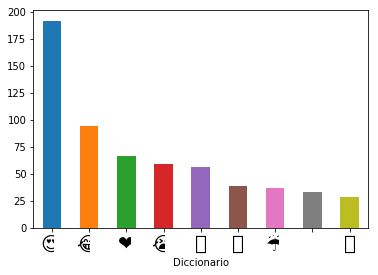

In [166]:
figsize = (20,50)
ax = tot.iloc[0:9].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar', legend = None)
ax.set_xticklabels(a, rotation = 0, fontsize = 20)

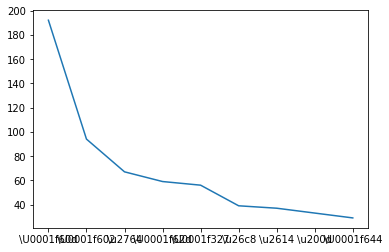

In [170]:
plt.plot(tot['Diccionario'].iloc[0:9].values, tot['Frecuencia'].iloc[0:9].values)

In [168]:
tot['Diccionario'].iloc[0:9].values

array(['\\U0001f60d', '\\U0001f602', '\\u2764', '\\U0001f62d',
       '\\U0001f327', '\\u26c8', '\\u2614', '\\u200d', '\\U0001f644'],
      dtype=object)

In [193]:
import matplotlib.pyplot as plt, numpy as np
from matplotlib.font_manager import FontProperties

# Load Apple Color Emoji font 
prop = FontProperties(fname='AppleColorEmoji.ttc')
plt.rcParams['font.family'] = prop.get_family()

# Set up plot
freqs = [301, 96, 53, 81, 42]
labels = ['😊', '😱', '😂', '😄', '😛']
plt.figure(figsize=(12,8))
p1 = plt.bar(np.arange(len(labels)), freqs, 0.8, color="lightblue")
plt.ylim(0, plt.ylim()[1]+30)

# Make labels
#for rect1, label in zip(p1, labels):
#    height = rect1.get_height()
plt.xticks(np.arange(len(labels)),labels,fontsize=30,fontproperties=prop)
#plt.xticks(np.arange(len(labels)),labels, fontsize = 30, fontname = prop)
#plt.xticks(np.arange(len(labels)), ['1', '2', '3', '4', '5'])
plt.show()

RuntimeError: In FT2Font: Could not set the fontsize

<Figure size 864x576 with 1 Axes>

Text(0.5,0.8,'😢')

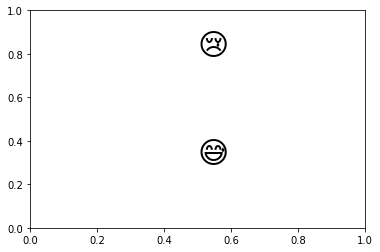

In [194]:
plt.rcParams['font.family'] = prop.get_family()

plt.annotate("😅", (0.5, 0.3), size=30)
plt.annotate("😢", (0.5, 0.8), size=30)

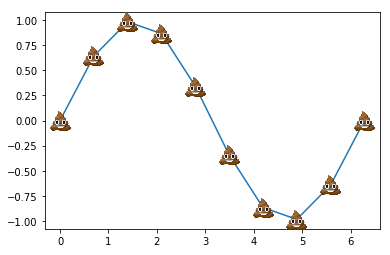

In [2]:
from os.path import join, dirname, abspath
from matplotlib import pyplot
from matplotlib.cbook import get_sample_data
from numpy import linspace
from numpy.core.umath import pi
from numpy.ma import sin

# poo-mark came from emojipedia:
# https://emojipedia-us.s3.amazonaws.com/thumbs/120/apple/96/pile-of-poo_1f4a9.png
poo_img = pyplot.imread('/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/poo-mark.png')

x = linspace(0, 2*pi, num=10)
y = sin(x)

fig, ax = pyplot.subplots()
plot = ax.plot(x, y, linestyle="-")

ax_width = ax.get_window_extent().width
fig_width = fig.get_window_extent().width
fig_height = fig.get_window_extent().height
poo_size = ax_width/(fig_width*len(x))
poo_axs = [None for i in range(len(x))]
for i in range(len(x)):
    loc = ax.transData.transform((x[i], y[i]))
    poo_axs[i] = fig.add_axes([loc[0]/fig_width-poo_size/2, loc[1]/fig_height-poo_size/2,
                               poo_size, poo_size], anchor='C')
    poo_axs[i].imshow(poo_img)
    poo_axs[i].axis("off")
fig.savefig("poo_plot.png")
